In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import warnings
from scipy.optimize import curve_fit, minimize
from wafer_plot import draw_wafer_plot

warnings.filterwarnings('ignore')

In [59]:
def cross_func(x, a, L_pi, phi):  # sine squared
    return a * (np.sin(np.pi * x / (2 * L_pi) - phi)) ** 2

def bar_func(x, a, L_pi, phi, P):  # cosine squared
    return P - a * (np.sin(np.pi * x / (2 * L_pi) - phi)) ** 2

def combined_func(x, a, L_pi, phi, P):
    return np.hstack((cross_func(x, a, L_pi, phi), bar_func(x, a, L_pi, phi, P)))

def objective(params, x_data, y_data1, y_data2):
    residuals1 = y_data1 - cross_func(x_data, *params[0:-1])
    residuals2 = y_data2 - bar_func(x_data, *params[0:-1], params[-1])

    ssq1, ssq2 = np.sum(residuals1**2), np.sum(residuals2**2)  # "residuals" needs to be a numpy array
    return ssq1 + ssq2

In [19]:
root_path = Path('/Users/jiahaozhan/Google Drive/Other Computers/CM300/Dione_wafer3_BO')
data_path = root_path / 'dcoupler_splitter_calib_test_cells_BO_wafer3'

gap_widths = np.array([0.18, 0.19, 0.2, 0.205])
lengths = np.array([1.0, 1.35, 1.7, 2.05, 2.4, 2.75, 3.1, 3.45, 3.8, 4.15, 4.5, 4.85, 5.2, 5.55, 5.9, 6.25, 6.6, 6.95, 7.3, 7.65])
print(len(lengths))
ret_num = 26

data_dir_gen = sorted(data_path.glob(f'reticle{ret_num}/*.json'))
for d in data_dir_gen:
    df = pd.read_json(d)
    ret = int(df['reticle'][0])

    wavel = df['wavelength']
    trans = df['transmission_ch1']

bar = {}
cross = {}
for i, g in enumerate(gap_widths):
    bar[g] = []
    cross[g] = []
    for j, l in enumerate(lengths):
        bar[g].append(trans[i*len(lengths)*2 + j*2][2500])  # 2500 is the index for wavelength 1310 nm
        cross[g].append(trans[i*len(lengths)*2 + j*2 + 1][2500])

print(bar)
print(cross)

dBm_to_mW = lambda p_dBm: 10 ** np.divide(np.array(p_dBm), 10)
bar_lin = {gap:dBm_to_mW(trans) for gap, trans in bar.items()}
cross_lin = {gap:dBm_to_mW(trans) for gap, trans in cross.items()}


# get a wafer plot
# draw_wafer_plot(data=losses, title=df['test_cell'][0])

20
{0.18: [-14.8283004761, -15.1744451523, -15.435874939, -15.5986118317, -15.734621048, -15.4876317978, -15.3186340332, -15.2933740616, -15.0117282867, -14.9804477692, -14.222035408, -14.0432720184, -13.7957401276, -13.5204105377, -13.2083616257, -12.7974700928, -12.6607913971, -12.5468835831, -12.3960695267, -12.2837867737], 0.19: [-14.5894956589, -14.9499721527, -15.0773220062, -15.2686510086, -15.4242134094, -15.425778389, -15.3701133728, -15.2646274567, -15.0094690323, -14.853201866100001, -14.4571495056, -13.9725112915, -13.9440574646, -13.5970153809, -13.1237878799, -12.9332551956, -12.6583366394, -12.436848640400001, -12.2567100525, -12.1644639969], 0.2: [-14.0649614334, -14.3728055954, -14.5483551025, -14.7844009399, -15.0216341019, -15.1613197327, -15.0758743286, -15.0068483353, -14.7424516678, -14.6760120392, -14.4863119125, -14.332359314, -13.9933166504, -13.6674394608, -13.3652381897, -13.013250351, -12.8877906799, -12.7364883423, -12.3846588135, -12.4485282898], 0.205: [-

In [20]:
g = gap_widths[0]
x_data, bar_data, cross_data = lengths, bar_lin[g], cross_lin[g]

new_len = np.arange(lengths[0], lengths[-1], 0.01)
params_init = [0.025, 5.5, -0.25*np.pi, 0.048]

popt_b, pcov_b = curve_fit(bar_func, x_data, bar_data, p0=params_init)
print(popt_b)
y_predicted = bar_func(x_data, *popt_b)
residuals = bar_data - y_predicted
ss_total = np.sum((bar_data - np.mean(bar_data))**2)
ss_residual = np.sum(residuals**2)
r_squared_b = 1 - (ss_residual / ss_total)
print(r_squared_b)

popt_c, pcov_c = curve_fit(cross_func, x_data, cross_data, p0=params_init[0:-1])
print(popt_c)
y_predicted = cross_func(x_data, *popt_c)
residuals = cross_data - y_predicted
ss_total = np.sum((cross_data - np.mean(cross_data))**2)
ss_residual = np.sum(residuals**2)
r_squared_c = 1 - (ss_residual / ss_total)
print(r_squared_c)

popt, pcov = curve_fit(combined_func, x_data, np.hstack((cross_data, bar_data)), p0=params_init, maxfev=5000)
print(popt)
stacked_data = np.hstack((cross_data, bar_data))
y_predicted = combined_func(x_data, *popt)
residuals = stacked_data - y_predicted
ss_total = np.sum((stacked_data - np.mean(stacked_data))**2)
ss_residual = np.sum(residuals**2)
r_squared = 1 - (ss_residual / ss_total)
print(r_squared)

[ 0.03248934  5.75463111 -0.89119963  0.05991262]
0.9951606927225843
[ 0.03340242  5.34003568 -0.83581222]
0.9939337631577182
[ 0.03273352  5.50914112 -0.85939312  0.05947569]
0.9955978468316136


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


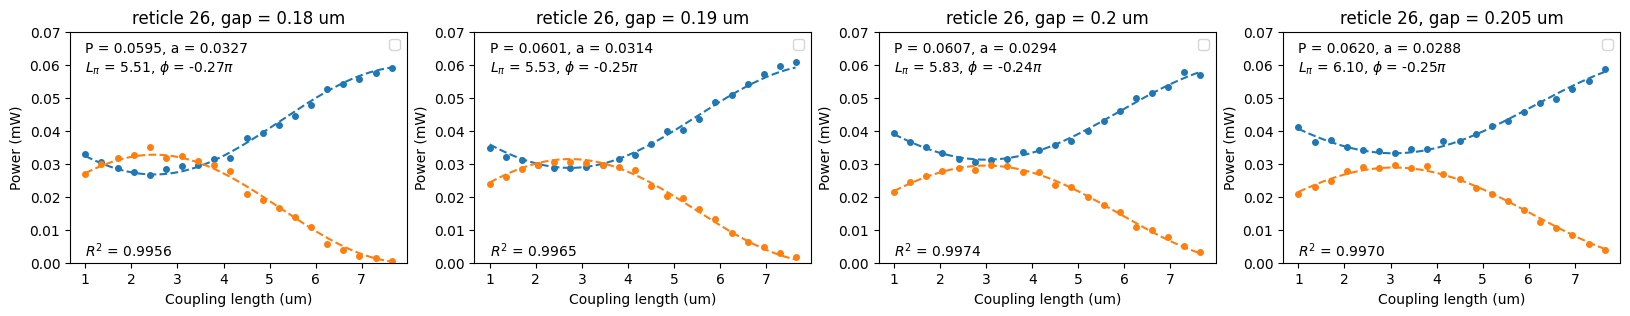

In [60]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# make plots
fig, axes = plt.subplots(1, 4, figsize = (20, 3))
for i, g in enumerate(gap_widths):
    # fit data
    x_data, bar_data, cross_data = lengths, bar_lin[g], cross_lin[g]

    new_len = np.arange(lengths[0], lengths[-1], 0.01)
    params_init = [0.025, 5, 0*np.pi, 0.05]
    popt, pcov = curve_fit(combined_func, x_data, np.hstack((cross_data, bar_data)), p0=params_init, maxfev=5000)
    stacked_data = np.hstack((cross_data, bar_data))
    y_predicted = combined_func(x_data, *popt)
    residuals = stacked_data - y_predicted
    ss_total = np.sum((stacked_data - np.mean(stacked_data))**2)
    ss_residual = np.sum(residuals**2)
    r_squared = 1 - (ss_residual / ss_total)
    
    # Plot the data
    ax = axes[i]
    # label_b = '$L_{\pi}$, $\phi$ = ' + f"{p_opt_b[2]:.2f}, {p_opt_b[3]/np.pi:.2f}" + '$\pi$'
    ax.plot(lengths, bar_lin[g], 'o', color=colors[0], markersize=4)
    ax.plot(new_len, bar_func(new_len, *popt), '--', color=colors[0])

    # label_c = '$L_{\pi}$, $\phi$ = ' + f"{p_opt_c[2]:.2f}, {p_opt_c[3]/np.pi:.2f}" + '$\pi$'
    ax.plot(lengths, cross_lin[g], 'o', color=colors[1], markersize=4)
    ax.plot(new_len, cross_func(new_len, *popt[0:-1]), '--', color=colors[1])
    
    ax.set_xlabel('Coupling length (um)')
    ax.set_ylabel('Power (mW)')
    ax.set_title(f'reticle {ret_num}, gap = {g} um')
    # ax.set_xlim([0, 8])
    ax.set_ylim([0, 0.07])
    ax.text(1, 0.002, '$R^2$' + f' = {r_squared:.4f}')
    ax.text(1, 0.058, f'P = {popt[3]:.4f}, a = {popt[0]:.4f}' + '\n'
            + '$L_{\pi}$ = ' + f"{popt[1]:.2f}, " + '$\phi$ = ' + f"{popt[2]/np.pi:.2f}" + '$\pi$')
    ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5


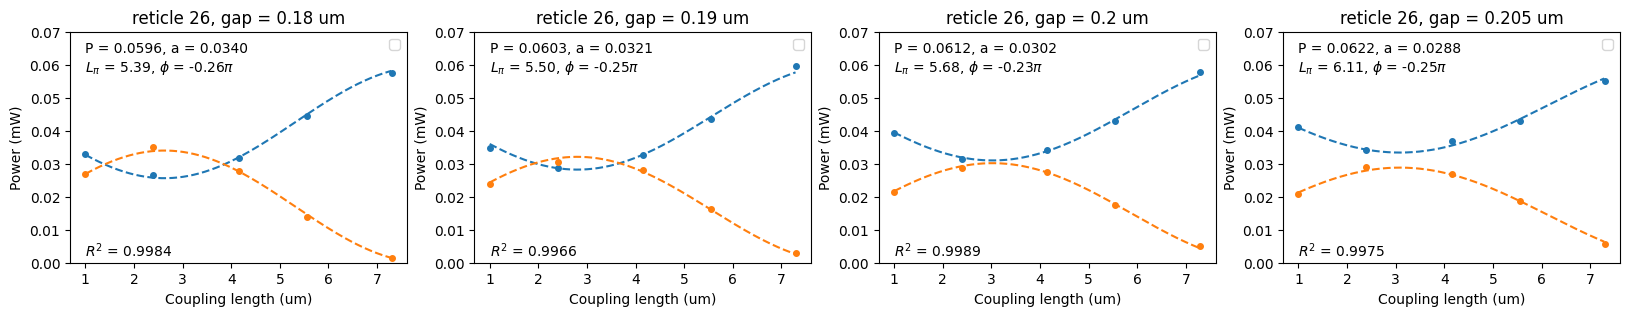

In [58]:
# reduce the number of data points
id = [0,4,9,13,18]
print(len(id))

# make plots
fig, axes = plt.subplots(1, 4, figsize = (20, 3))
for i, g in enumerate(gap_widths):
    # fit data
    x_data, bar_data, cross_data = lengths[id], bar_lin[g][id], cross_lin[g][id]

    new_len = np.arange(lengths[0], lengths[-2], 0.01)
    params_init = [0.025, 5.1, 0*np.pi, 0.05]
    popt, pcov = curve_fit(combined_func, x_data, np.hstack((cross_data, bar_data)), p0=params_init, maxfev=5000)
    stacked_data = np.hstack((cross_data, bar_data))
    y_predicted = combined_func(x_data, *popt)
    residuals = stacked_data - y_predicted
    ss_total = np.sum((stacked_data - np.mean(stacked_data))**2)
    ss_residual = np.sum(residuals**2)
    r_squared = 1 - (ss_residual / ss_total)
    
    # Plot the data
    ax = axes[i]
    # label_b = '$L_{\pi}$, $\phi$ = ' + f"{p_opt_b[2]:.2f}, {p_opt_b[3]/np.pi:.2f}" + '$\pi$'
    ax.plot(lengths[id], bar_lin[g][id], 'o', color=colors[0], markersize=4)
    ax.plot(new_len, bar_func(new_len, *popt), '--', color=colors[0])

    # label_c = '$L_{\pi}$, $\phi$ = ' + f"{p_opt_c[2]:.2f}, {p_opt_c[3]/np.pi:.2f}" + '$\pi$'
    ax.plot(lengths[id], cross_lin[g][id], 'o', color=colors[1], markersize=4)
    ax.plot(new_len, cross_func(new_len, *popt[0:-1]), '--', color=colors[1])
    
    ax.set_xlabel('Coupling length (um)')
    ax.set_ylabel('Power (mW)')
    ax.set_title(f'reticle {ret_num}, gap = {g} um')
    # ax.set_xlim([0, 8])
    ax.set_ylim([0, 0.07])
    ax.text(1, 0.002, '$R^2$' + f' = {r_squared:.4f}')
    ax.text(1, 0.058, f'P = {popt[3]:.4f}, a = {popt[0]:.4f}' + '\n'
            + '$L_{\pi}$ = ' + f"{popt[1]:.2f}, " + '$\phi$ = ' + f"{popt[2]/np.pi:.2f}" + '$\pi$')
    ax.legend()